In [65]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from xgboost import XGBClassifier, XGBRFClassifier

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [2]:
''' reading data '''
df = pd.read_csv('Social_Network_Ads.csv')

In [3]:
''' displaying first 5 rows '''
df.head()

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


In [4]:
''' shape of data '''
df.shape

(400, 3)

In [5]:
''' checking null values '''
df.isnull().sum()

Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [6]:
''' describing data '''
df.describe()

,Age,EstimatedSalary,Purchased
count,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500
std,10.482877,34096.960282,0.479864
min,18.000000,15000.000000,0.000000
25%,29.750000,43000.000000,0.000000
50%,37.000000,70000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,150000.000000,1.000000


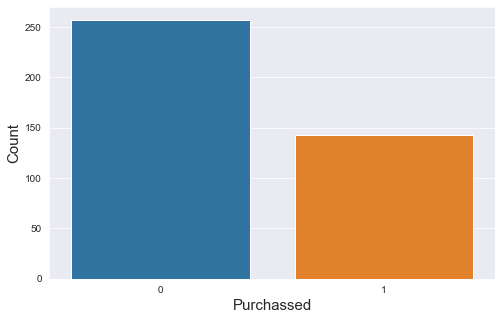

In [9]:
''' value count of purchased '''
purch = df.Purchased.value_counts()

''' barplot '''
plt.figure(figsize=(8, 5))
sns.barplot(purch.index, purch);
plt.xlabel('Purchassed', fontsize=15)
plt.ylabel('Count', fontsize=15);

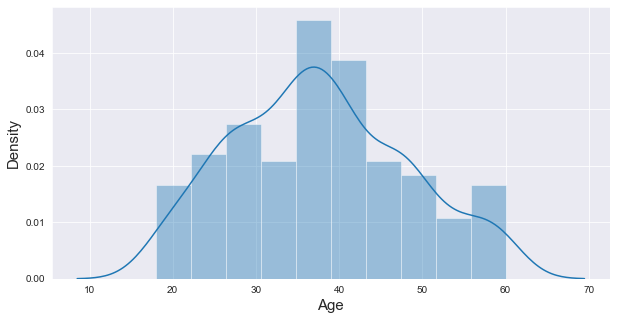

In [12]:
''' distribution plot '''
plt.figure(figsize=(10, 5))
sns.distplot(df['Age'])
plt.xlabel('Age', fontsize=15)
plt.ylabel('Density', fontsize=15);

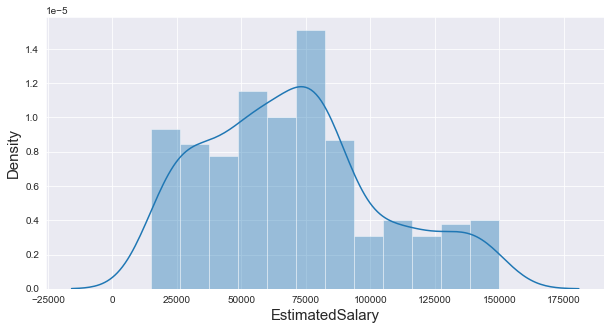

In [13]:
''' distribution plot of EstimatedSalary '''
plt.figure(figsize=(10, 5))
sns.distplot(df['EstimatedSalary'])
plt.xlabel('EstimatedSalary', fontsize=15)
plt.ylabel('Density', fontsize=15);

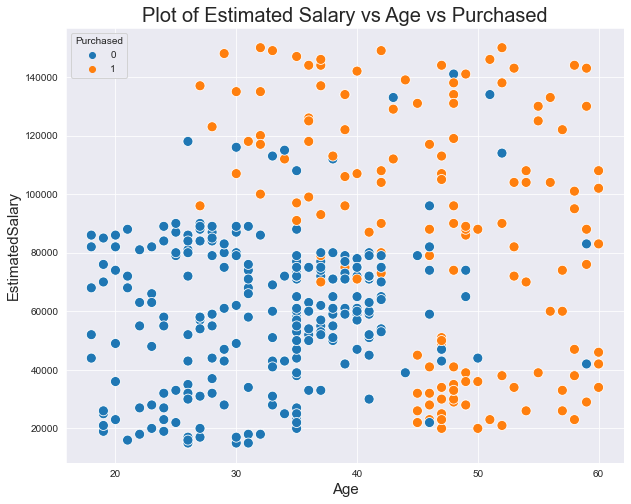

In [18]:
''' scatter plot '''
plt.figure(figsize=(10,8))
plt.title('Plot of Estimated Salary vs Age vs Purchased', fontsize=20)
plt.xlabel('Age', fontsize=15)
plt.ylabel('EstimatedSalary', fontsize=15)
sns.scatterplot(data=df,x='Age',y= 'EstimatedSalary', hue='Purchased', s=100);

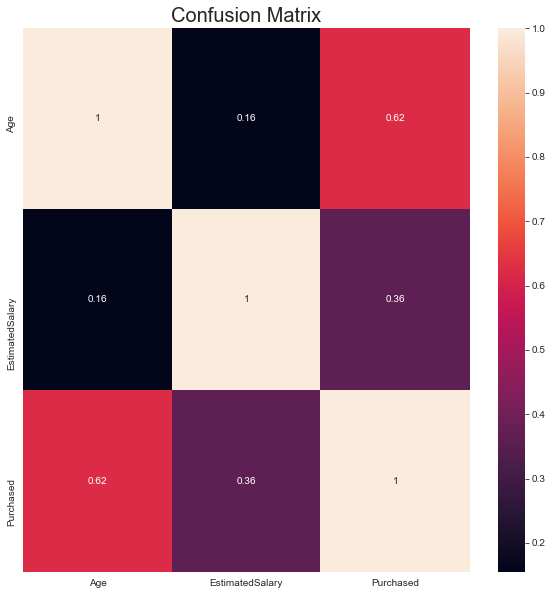

In [19]:
''' correlation matrix '''
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True)
plt.title('Confusion Matrix', fontsize=20);

In [21]:
''' independent and dependent variables '''
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [22]:
X.head()

,Age,EstimatedSalary
0,19,19000
1,35,20000
2,26,43000
3,27,57000
4,19,76000


In [24]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Purchased, dtype: int64

In [30]:
''' train test split '''
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [31]:
''' scaling '''
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [32]:
def scores(m, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    
    ms = {}
    
    for n, model in m.items():
        model.fit(X_train,y_train)
        ms[n] = model.score(X_test,y_test)

    ms = pd.DataFrame(ms, index=['Score']).transpose()
    ms = ms.sort_values('Score')
        
    return ms

In [33]:
models = {'LogisticRegression': LogisticRegression(max_iter=10000),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'SVC': SVC(),
          'DecisionTreeClassifier': DecisionTreeClassifier(),
          'RandomForestClassifier': RandomForestClassifier(),
          'AdaBoostClassifier': AdaBoostClassifier(),
          'GradientBoostingClassifier': GradientBoostingClassifier(),
          'XGBClassifier': XGBClassifier(eval_metric='mlogloss'),
          'XGBRFClassifier': XGBRFClassifier(eval_metric='mlogloss')}

In [34]:
results  = scores(models, X_train, X_test, y_train, y_test)

In [35]:
results

,Score
DecisionTreeClassifier,0.8375
LogisticRegression,0.8625
GradientBoostingClassifier,0.8625
RandomForestClassifier,0.8875
AdaBoostClassifier,0.8875
KNeighborsClassifier,0.9125
XGBClassifier,0.9125
SVC,0.9250
XGBRFClassifier,0.9250


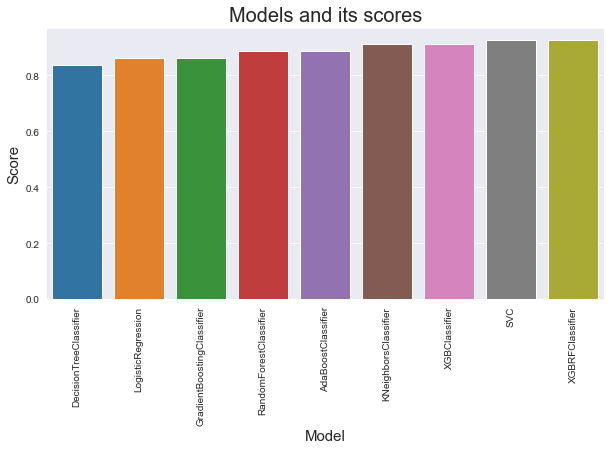

In [45]:
''' barplot of results '''
plt.figure(figsize=(10, 5))
plt.xticks(rotation=90)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.title("Models and its scores", fontsize=20)
sns.barplot(results.index, results.Score.values);

In [41]:
''' hyperparameter tunning '''

array([[0.8375],
       [0.8625],
       [0.8625],
       [0.8875],
       [0.8875],
       [0.9125],
       [0.9125],
       [0.925 ],
       [0.925 ]])

In [47]:
def rs_cv_sc(m, p, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    
    mrs = {}
    mrbs = {}
    
    for name, model in m.items():
        rs_model = RandomizedSearchCV(model, param_distributions=p[name], cv=5, n_iter=20, verbose=1)
        rs_model.fit(X_train,y_train)
        mrs[name] = rs_model.score(X_test,y_test)
        mrbs[name] = rs_model.best_params_
        
    return mrs, mrbs

In [48]:
''' RandomSearch CV 1 '''

params = {'KNeighborsClassifier' : {'n_neighbors': np.arange(1,100,10)},
          'XGBClassifier': {'learning_rate': np.linspace(0,1,20),
                            'gamma': [0,2,4,10,20,50],
                            'max_depth': [2,3,6,10,20],
                            'lambda': [0,1],
                            'alpha' : [0,0.1,0.2,0.5,0.8,1],
                            },
          'XGBRFClassifier': {'learning_rate': np.linspace(0,1,20),
                              'max_depth': [2,3,6,10,20],
                              },
          'SVC' : {'C': [0.1,0.5,1, 10,100,500], 
                   'kernel':['linear', 'poly', 'rbf','sigmoid'],
                   'gamma':['scale','auto'],
                   'degree':[2,3,4,5,6,7]}
          }
models = {'KNeighborsClassifier': KNeighborsClassifier(),
         'XGBClassifier': XGBClassifier(eval_metric='mlogloss'),
         'XGBRFClassifier': XGBRFClassifier(eval_metric='mlogloss'),
         'SVC': SVC()
         }

In [49]:
mrs, mrbs = rs_cv_sc(models, params, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [50]:
mrs

{'KNeighborsClassifier': 0.925,
 'XGBClassifier': 0.9125,
 'XGBRFClassifier': 0.9125,
 'SVC': 0.9375}

In [51]:
mrbs

{'KNeighborsClassifier': {'n_neighbors': 11},
 'XGBClassifier': {'max_depth': 2,
  'learning_rate': 0.631578947368421,
  'lambda': 0,
  'gamma': 20,
  'alpha': 0},
 'XGBRFClassifier': {'max_depth': 2, 'learning_rate': 0.47368421052631576},
 'SVC': {'kernel': 'rbf', 'gamma': 'scale', 'degree': 7, 'C': 0.5}}

In [52]:
''' RandomSearch CV 2 '''

params = {'KNeighborsClassifier' : {'n_neighbors': np.arange(1,15)},
          'XGBClassifier': {'learning_rate': [0.631578947368421],
                            'gamma': [15,20,25],
                            'max_depth': [2],
                            'lambda': [0,1],
                            'alpha' : [0],
                            },
          'XGBRFClassifier': {'learning_rate': [0.47368421052631576],
                              'max_depth': [2],
                              },
          'SVC' : {'C': [0.3,0.4,0.5,0.6,0.7], 
                   'kernel':['rbf'],
                   'gamma':['scale'],
                   'degree':[7,8,9,10,15,20]}
          }
models = {'KNeighborsClassifier': KNeighborsClassifier(),
         'XGBClassifier': XGBClassifier(eval_metric='mlogloss'),
         'XGBRFClassifier': XGBRFClassifier(eval_metric='mlogloss'),
         'SVC': SVC()
         }

In [53]:
mrs1, mrbs1 = rs_cv_sc(models, params, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [54]:
mrs1

{'KNeighborsClassifier': 0.9375,
 'XGBClassifier': 0.9125,
 'XGBRFClassifier': 0.9125,
 'SVC': 0.925}

In [55]:
mrbs1

{'KNeighborsClassifier': {'n_neighbors': 9},
 'XGBClassifier': {'max_depth': 2,
  'learning_rate': 0.631578947368421,
  'lambda': 0,
  'gamma': 15,
  'alpha': 0},
 'XGBRFClassifier': {'max_depth': 2, 'learning_rate': 0.47368421052631576},
 'SVC': {'kernel': 'rbf', 'gamma': 'scale', 'degree': 20, 'C': 0.6}}

In [60]:
''' KNN '''
knn = KNeighborsClassifier()

''' fit on data '''
knn.fit(X_train, y_train)

''' prediction '''
preds = knn.predict(X_test)

In [61]:
print("Classification Report: \n", classification_report(y_test, preds))

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93        52
           1       0.86      0.89      0.88        28

    accuracy                           0.91        80
   macro avg       0.90      0.91      0.90        80
weighted avg       0.91      0.91      0.91        80



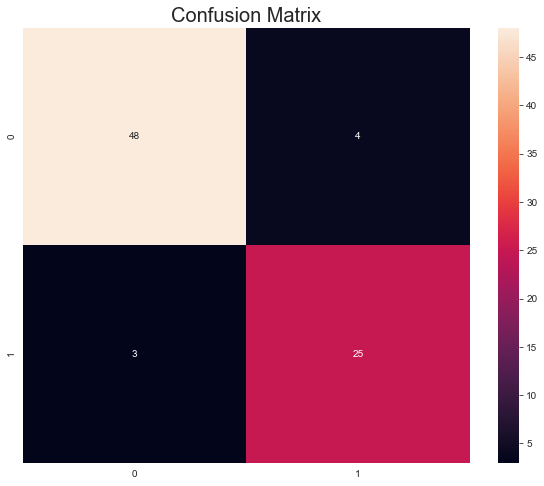

In [70]:
''' confusion matrix '''
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, preds), annot=True)
plt.title('Confusion Matrix', fontsize=20);

<Figure size 720x360 with 0 Axes>

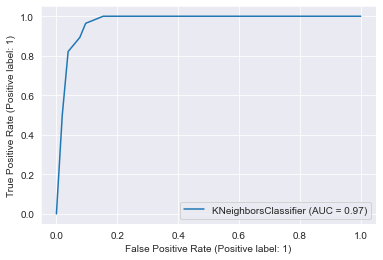

In [69]:
plt.figure(figsize=(10, 5))
plot_roc_curve(knn, X_test,y_test);